In [16]:
# import necessary lib
from PIL import Image, ImageFilter
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage

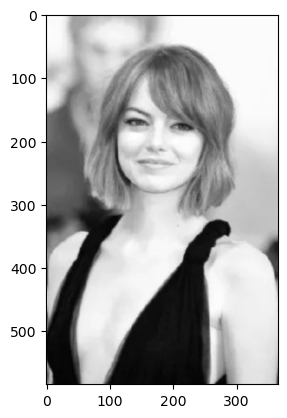

In [17]:
# Read Picture
img = Image.open('female.png').convert('L')
plt.imshow(img, cmap='gray')

<class 'numpy.ndarray'>


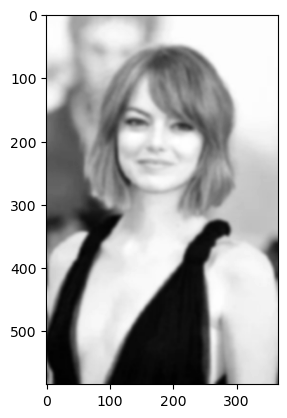

In [18]:
# gaussian filter
img_blur = img.filter(ImageFilter.GaussianBlur(radius=2))
img_blur = np.array(img_blur).astype('int')
plt.imshow(img_blur, cmap='gray')
print(type(img_blur))

In [19]:
# find gradient and calculate ctan
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

grad_x = ndimage.convolve(img_blur, sobel_x)
grad_y = ndimage.convolve(img_blur, sobel_y)

total_grad = np.sqrt(grad_x ** 2 + grad_y ** 2)
theta = np.arctan2(grad_y, grad_x)

3.141592653589793 -3.1368080011064348


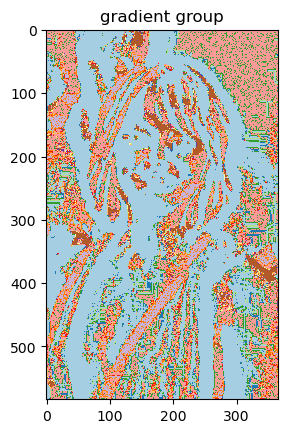

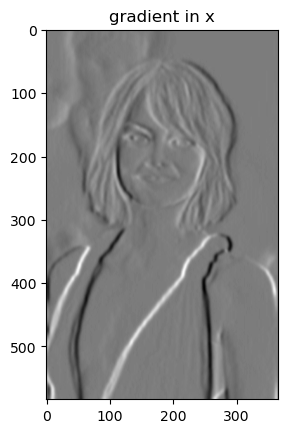

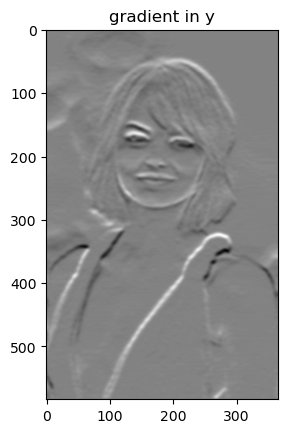

In [20]:
# group grads into 4 directions
grad_map = np.zeros_like(theta)

grad_map[((theta >= -np.pi / 8) * (theta <= np.pi / 8))] = 1  # x
grad_map[((theta > np.pi / 8) * (theta < np.pi * 3 / 8))] = 2  # 45
grad_map[((theta > -np.pi * 3 / 8) * (theta < -np.pi / 8))] = 3  # 135
# 0   # y

print(np.max(theta), np.min(theta))
plt.figure(0)
plt.title('gradient group')
plt.imshow(grad_map, cmap='Paired')
plt.figure(1)
plt.title('gradient in x')
plt.imshow(grad_x, cmap='gray')
plt.figure(2)
plt.title('gradient in y')
plt.imshow(grad_y, cmap='gray')

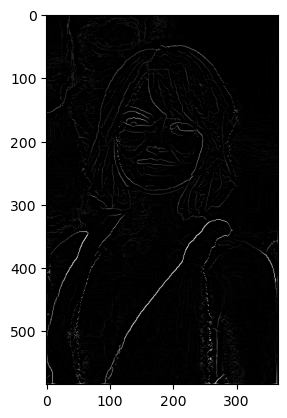

In [21]:
# Non-maximum suppression
suppression_img = total_grad.copy()
for i in range(1, img.size[1] - 1):
    for j in range(1, img.size[0] - 1):
        label = grad_map[i][j]
        grad = total_grad[i][j]

        if label == 0:  # y
            if grad < total_grad[i + 1][j] or grad < total_grad[i - 1][j]:
                suppression_img[i][j] = 0

        if label == 1:  # x
            if grad < total_grad[i][j + 1] or grad < total_grad[i][j - 1]:
                suppression_img[i][j] = 0

        if label == 2:  # 45
            if grad < total_grad[i + 1][j + 1] or grad < total_grad[i - 1][j - 1]:
                suppression_img[i][j] = 0

        if label == 3:  # 135
            if grad < total_grad[i + 1][j - 1] or grad < total_grad[i - 1][j + 1]:
                suppression_img[i][j] = 0


plt.imshow(suppression_img, cmap='gray')

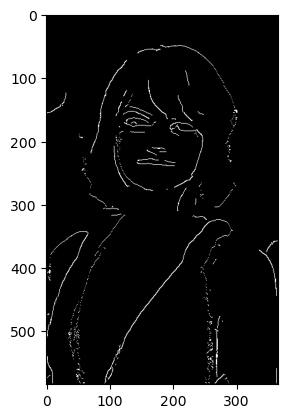

In [35]:
# Thresholding & linking
thres_img  = np.zeros(suppression_img.shape)
mmax = np.max(suppression_img)
thres_low = 40
thres_high = 70

strongs = set()

for i in range(1, suppression_img.shape[0] - 1):
    for j in range(1, suppression_img.shape[1] - 1):
        px = suppression_img[i][j]
        if px >= thres_high:
            thres_img[i][j] = 255
            strongs.add((i, j))
        elif px >= thres_low:
            # connect weak edge and strong edge, remove isolated weakedge
            for m in [(i - 1, j - 1), (i - 1, j), (i - 1, j + 1),
                      (i, j - 1), (i, j), (i, j + 1),
                      (i + 1, j - 1), (i + 1, j), (i + 1, j + 1),]:
                if m in strongs:
                    thres_img[i][j] = 255
                    strongs.add((i, j))
                    break

plt.imshow(thres_img, cmap='gray')